In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd

import wandb
import datetime
from tqdm.auto import tqdm

from timm.models import resnet18, efficientnetv2_s, vit_tiny_r_s16_p8_224, vit_small_r26_s32_224, InceptionResnetV2, efficientnetv2_m
from torchsummary import summary

In [2]:
model = efficientnetv2_s().cuda()

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 64, 64]             648
          Identity-2           [-1, 24, 64, 64]               0
              SiLU-3           [-1, 24, 64, 64]               0
    BatchNormAct2d-4           [-1, 24, 64, 64]              48
            Conv2d-5           [-1, 24, 64, 64]           5,184
          Identity-6           [-1, 24, 64, 64]               0
              SiLU-7           [-1, 24, 64, 64]               0
    BatchNormAct2d-8           [-1, 24, 64, 64]              48
          Identity-9           [-1, 24, 64, 64]               0
        ConvBnAct-10           [-1, 24, 64, 64]               0
           Conv2d-11           [-1, 24, 64, 64]           5,184
         Identity-12           [-1, 24, 64, 64]               0
             SiLU-13           [-1, 24, 64, 64]               0
   BatchNormAct2d-14           [-1, 24,

In [3]:
df = pd.read_csv("/opt/ml/level3_cv_finalproject-cv-01/model/data/data.csv")
df.head()

,id,class_id,label,img_path,json_path
0,0,1,baek_sook,./data/image/baek_sook/baek_sook_0001.jpg,./data/json/baek_sook/1_korea_baek_sook.json
1,1,2,baek_sook,./data/image/baek_sook/baek_sook_0002.jpg,./data/json/baek_sook/2_korea_baek_sook.json
2,2,3,baek_sook,./data/image/baek_sook/baek_sook_0003.jpg,./data/json/baek_sook/3_korea_baek_sook.json
3,3,4,baek_sook,./data/image/baek_sook/baek_sook_0004.jpg,./data/json/baek_sook/4_korea_baek_sook.json
4,4,5,baek_sook,./data/image/baek_sook/baek_sook_0005.jpg,./data/json/baek_sook/5_korea_baek_sook.json


In [4]:
base_path = "/opt/ml/level3_cv_finalproject-cv-01/model"
images_path = []
labels = []
for image_path, label in zip(df["img_path"], df["label"]):
    images_path.append(os.path.join(base_path, image_path))
    labels.append(label)

classes = sorted(set(labels))
cls2idx = {c:i for i, c in enumerate(classes)}
print(f"labels : {len(labels)}, classes : {len(classes)}")

labels : 94963, classes : 93


In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from dataset import *

tf = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(transpose_mask=True),
])

train_dataset = CustomDataset(
            "/opt/ml/level3_cv_finalproject-cv-01/model", is_train=True, tf=tf
        )

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=8,
            drop_last=True,
        )

/tmp/ipykernel_8962/1021731531.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label).cuda()


max : 2.6399998664855957, min : -2.1179039478302
max : 7.329265117645264, min : -8.272359848022461
tensor([48, 48, 55, 64], device='cuda:0')
tensor([77, 28, 43, 58])
tensor(2.6400, device='cuda:0')
schweinshaxe


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


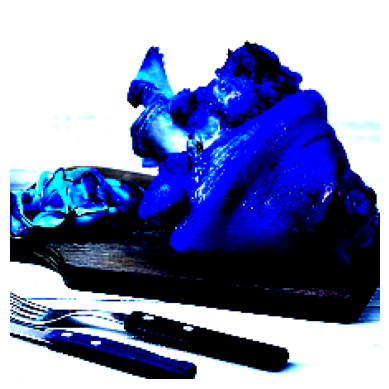

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


egg_benedict


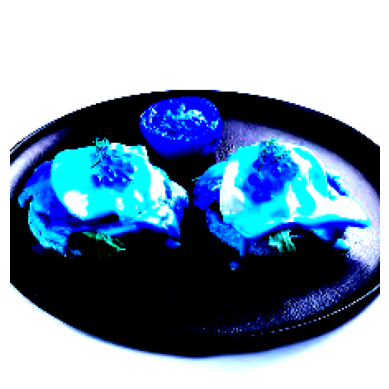

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


kaya_toast


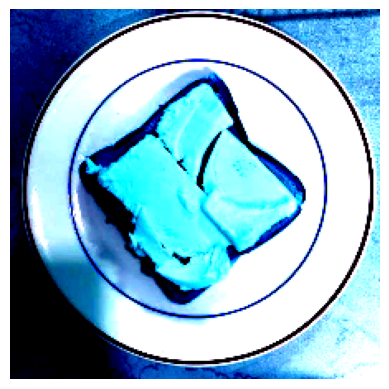

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


onigiri


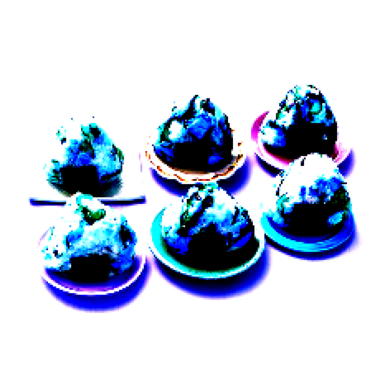

RuntimeError: No active exception to reraise

In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

model = torch.load('/opt/ml/level3_cv_finalproject-cv-01/model/save/Efficientnetv2_s_best.pth')
model.cuda()

with torch.no_grad():
    for image, label in train_loader:
        images = image.cuda()
        labels = torch.tensor(label).cuda()
        
        print(f"max : {torch.max(image)}, min : {torch.min(image)}")
        outputs = model(images)
        print(f"max : {torch.max(outputs)}, min : {torch.min(outputs)}")
        outputs = F.softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)
        print(outputs)
        print(label)
        print(torch.max(images))
        for i in range(images.shape[0]):
            image = images[i].cpu()
            image = image.permute(1, 2, 0)
            image_np = image.numpy()
            print(train_dataset.classes[labels[i].item()])
            plt.imshow(image_np)
            plt.axis('off')
            plt.show()
        raise